In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import joblib
from time import time
warnings.filterwarnings(action='ignore')

import seaborn as sns
sns.set_palette("pastel")
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')

In [5]:
# 경로 설정
card_r = pd.read_csv('CARD_SPENDING_RESIDENT.txt', sep = "\t")
cd = joblib.load('card_code_to_name_dict.pickle')

In [7]:
## 구, 동 이름 삽입
d_name = list(cd.items())[1][1]
g_name = list(cd.items())[0][1]

card_r['GU_DONG_CD'] = card_r['GU_CD'].astype('str')+card_r['DONG_CD'].astype('str')

gu_dong = pd.merge(pd.DataFrame(g_name.items()), pd.DataFrame(d_name.items()),on=0)
gu_dong['GU_DONG'] = gu_dong[['1_x','1_y']].apply(lambda x: ','.join(x), axis=1)
gu_dong = gu_dong.rename(columns={0: 'GU_DONG_CD'})[['GU_DONG_CD','GU_DONG']]

In [29]:
card = pd.merge(card_r,gu_dong,on='GU_DONG_CD')

In [30]:
## STD_DD(날짜) 변수 설정
card['DATE'] = card['STD_DD'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
card['YEAR'] = card['DATE'].dt.year
card['MONTH'] = card['DATE'].dt.month
card['WEEK'] = card['DATE'].dt.weekofyear

In [113]:
card.to_csv('card_resident.csv')

## Data Load

In [2]:
card = pd.read_csv('card_resident.csv')

In [3]:
# 음료/식품 보기
card_fb = card.query('MCT_CAT_CD == 81').reset_index(drop=True)

In [15]:
## 가중이동평균 구하기
def weightedMean(weightArray):
    def inner(x):
        return (weightArray * x).mean()
    return inner

n = 7
t = [v for v in np.arange(1, n+1)]
sumv = sum(t) / n
wts = np.array(t) / sumv

In [18]:
card_fb['CNT_roll'] = card_fb['USE_CNT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)

## EDA

## 전체 추이

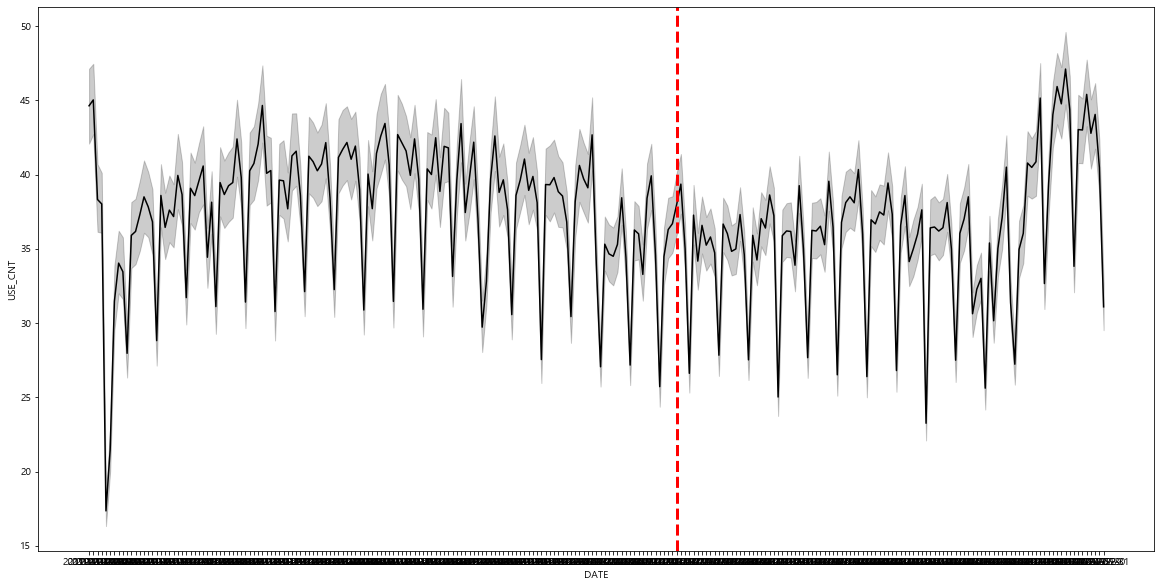

In [43]:
## 전체
plt.figure(figsize=(20,10))
sns.lineplot(data = card_fb, x = 'DATE', y = 'USE_CNT', color = 'k')
plt.axvline(x='2020-02-20', color='r', linestyle='--', linewidth=3)

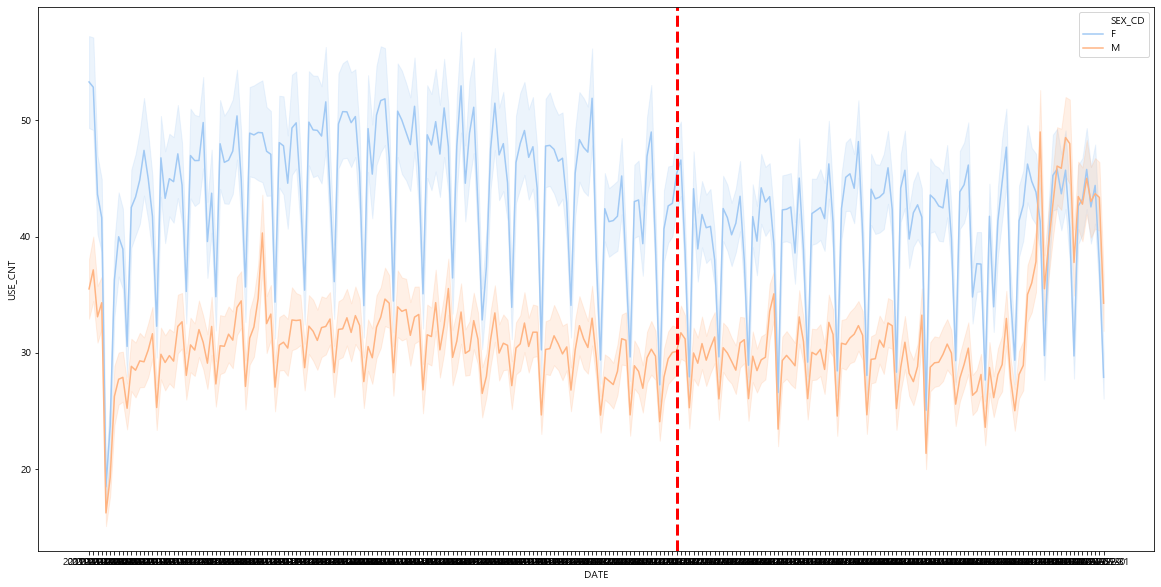

In [46]:
## 성별 => 여성에 비해서 남성의 방문 횟수가 적다가 4~5월 사이에 급격한 증가
plt.figure(figsize=(20,10))
sns.lineplot(data = card_fb, x = 'DATE', y = 'USE_CNT', hue='SEX_CD')
plt.axvline(x='2020-02-20', color='r', linestyle='--', linewidth=3)

<Figure size 1440x720 with 0 Axes>

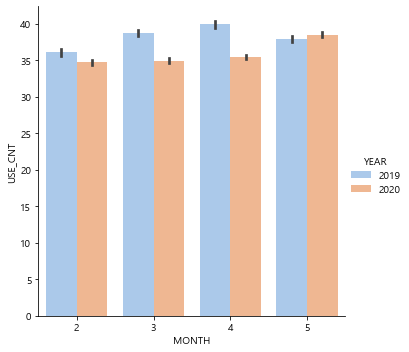

In [50]:
plt.figure(figsize=(20,10))
sns.catplot(data = card_fb, x = 'MONTH', y = 'USE_CNT', hue='YEAR', kind='bar')
#plt.axvline(x='2020-02-20', color='r', linestyle='--', linewidth=3)

KeyboardInterrupt: 

<Figure size 1440x720 with 0 Axes>

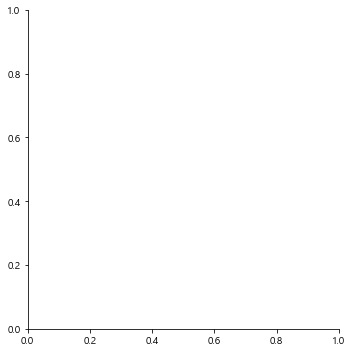

In [56]:
plt.figure(figsize=(20,10))
sns.catplot(data = card_fb, x = 'DATE', y = 'USE_CNT', hue='AGE_CD', kind='bar')

### 행정동 단위 분석 - 1. 전체 기간 CNT / AMT

<Figure size 864x864 with 0 Axes>

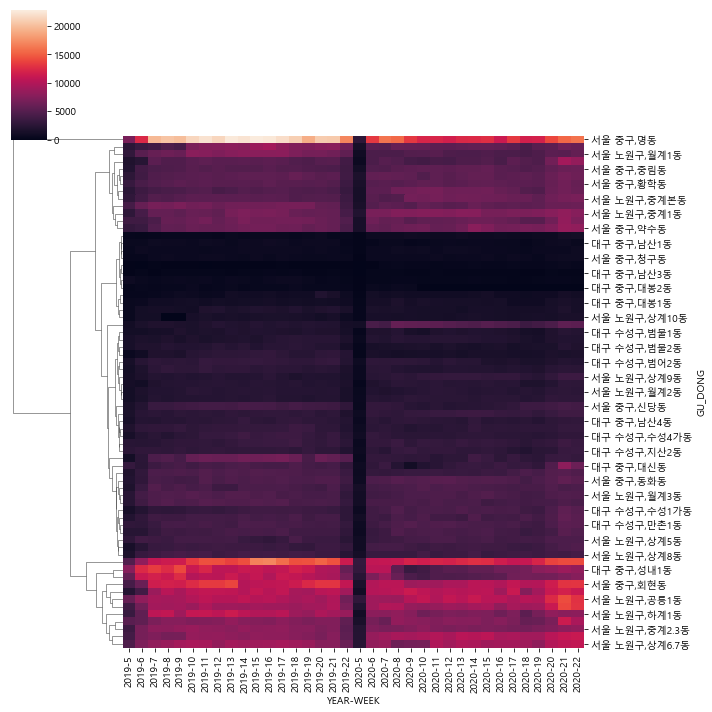

In [31]:
# USE_CNT
plt.figure(figsize=(12,12))
sns.clustermap(
    pd.pivot_table(
        card_fb.groupby(['GU_DONG','WEEK','YEAR'])['CNT_roll'].sum().reset_index(),
        index=['GU_DONG'],columns=['YEAR','WEEK'],values='CNT_roll'
    ).fillna(0), col_cluster=False
)

<Figure size 864x864 with 0 Axes>

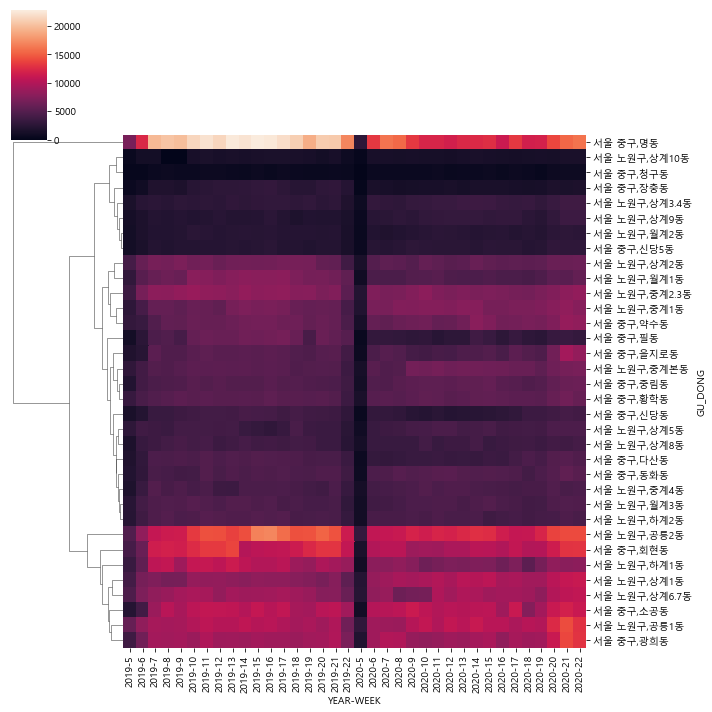

In [26]:
plt.figure(figsize=(12,12))
sns.clustermap(
    pd.pivot_table(
        card_fb.query('(GU_CD == 140) or (GU_CD == 350)').groupby(['GU_DONG','WEEK','YEAR'])['CNT_roll'].sum().reset_index(),
        index=['GU_DONG'],columns=['YEAR','WEEK'],values='CNT_roll'
    ).fillna(0), col_cluster=False
)

<Figure size 864x864 with 0 Axes>

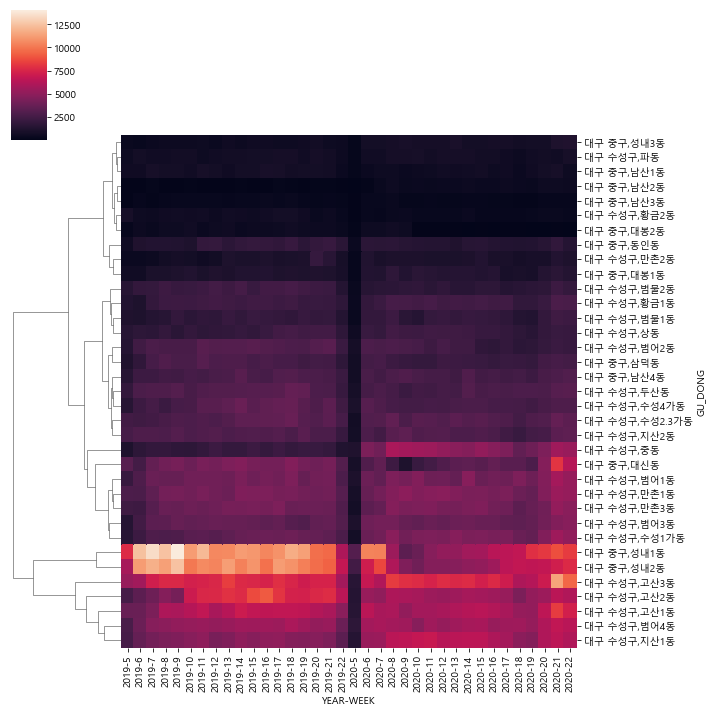

In [30]:
plt.figure(figsize=(12,12))
sns.clustermap(
    pd.pivot_table(
        card_fb.query('(GU_CD == 260) or (GU_CD == 110)').groupby(['GU_DONG','WEEK','YEAR'])['CNT_roll'].sum().reset_index(),
        index=['GU_DONG'],columns=['YEAR','WEEK'],values='CNT_roll'
    ).fillna(0), col_cluster=False
)

<Figure size 864x864 with 0 Axes>

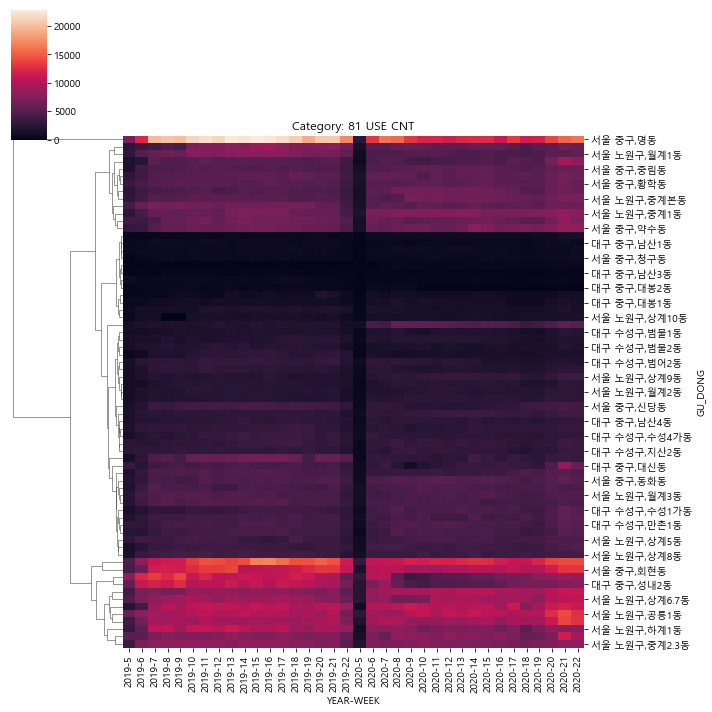

In [14]:
# 함수 설정 <= 아마도 이 포맷을 기본으로 내용만 수정하면 될 듯
def DongWeek_heatmap(card,i):
    plt.figure(figsize=(12,12))
    temp1 = card.query('MCT_CAT_CD == {}'.format(i))
    temp1['CNT_roll'] = temp1['USE_CNT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
    temp2 = temp1.groupby(['GU_DONG','YEAR', 'WEEK'])['CNT_roll'].sum().reset_index()
    temp2 = pd.pivot_table(temp2, index=['GU_DONG'],columns=['YEAR', 'WEEK'],values='CNT_roll').fillna(0)
    sns.clustermap(temp2,col_cluster=False).ax_heatmap.set_title('Category: ' + str(i) + ' USE CNT')

DongWeek_heatmap(card,81)

## 나이 단위 분석 - USE CNT / AMT

가중평균 X

<Figure size 1080x1080 with 0 Axes>

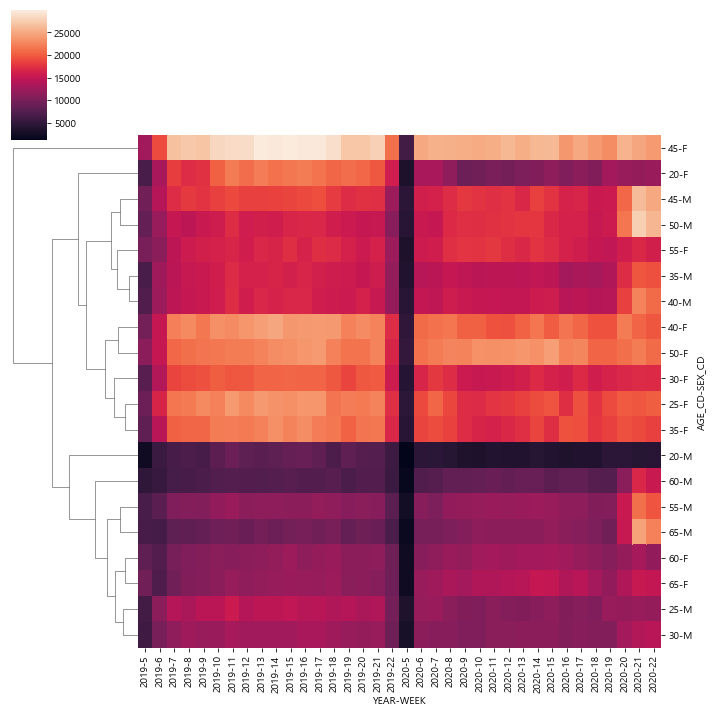

In [12]:
# USE CNT
plt.figure(figsize=(15,15))
sns.clustermap(
    pd.pivot_table(
        card_fb.groupby(['AGE_CD','SEX_CD','YEAR','WEEK'])['USE_CNT'].sum().reset_index(),
        index=['AGE_CD','SEX_CD'],columns=['YEAR','WEEK'],values='USE_CNT'
    ).fillna(0), col_cluster=False
)

가중평균 O

<Figure size 864x864 with 0 Axes>

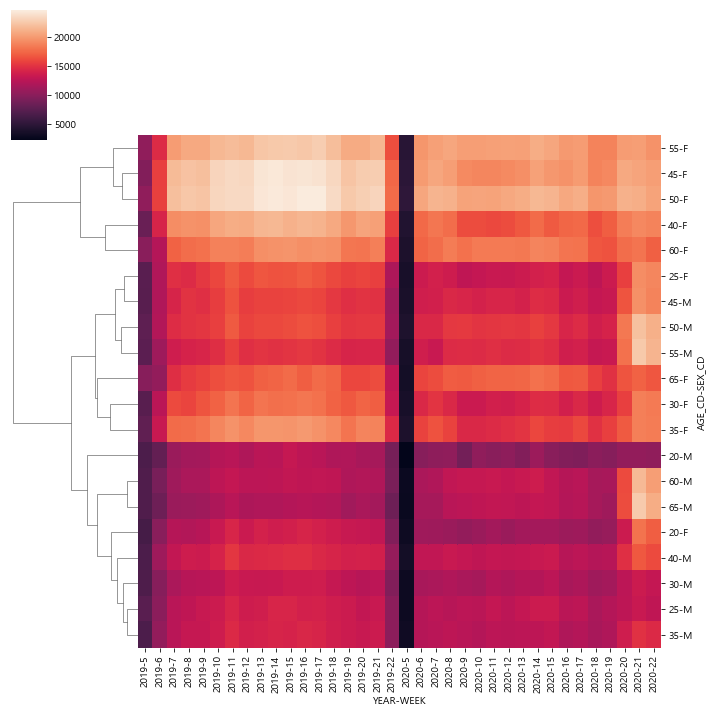

In [21]:
plt.figure(figsize=(12,12))
sns.clustermap(
    pd.pivot_table(
        card_fb.groupby(['AGE_CD','SEX_CD', 'WEEK','YEAR'])['CNT_roll'].sum().reset_index(),
        index=['AGE_CD','SEX_CD'],columns=['YEAR','WEEK'],values='CNT_roll'
    ).fillna(0), col_cluster=False
)

In [32]:
def AS_Week_heatmap(card,i):
    plt.figure(figsize=(12,12))
    temp1 = card.query('MCT_CAT_CD == {}'.format(i))
    temp1['CNT_roll'] = temp1['USE_CNT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
    temp2 = temp1.groupby(['GU_DONG','YEAR', 'WEEK'])['CNT_roll'].sum().reset_index()
    temp2 = pd.pivot_table(temp2, index=['GU_DONG'],columns=['YEAR', 'WEEK'],values='CNT_roll').fillna(0)
    sns.clustermap(temp2,col_cluster=False).ax_heatmap.set_title('Category: ' + str(i) + ' USE CNT')